💈 Développez un moteur de recommandation de films



## Preamble



### Imports



In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import warnings

from pandas.io.parsers.base_parser import _process_date_conversion
from scipy.stats.stats import describe
warnings.filterwarnings("ignore")
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#from lib import posters

import re
import json

from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler, MultiLabelBinarizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

# Out[24]:

### Functions



In [1]:
# Display all
def display_all(df):
    with pd.option_context("display.max_rows", 50, "display.max_columns", 25): 
        display(df)

# Out[2]:

## Data Prep



### Load Data



In [1]:
df_raw = pd.read_csv('../data/raw/movie_metadata.csv')

# Out[6]:

### Glimpse at the data



In [1]:
display_all(df_raw.describe(include='all').T)

# Out[7]:
|                           |   count |   unique | top                                                  |   freq |            mean |              std |     min |            25% |             50% |             75% |              max |
|---------------------------+---------+----------+------------------------------------------------------+--------+-----------------+------------------+---------+----------------+-----------------+-----------------+------------------|
| color                     |    5024 |        2 | Color                                                |   4815 |   nan           |    nan           |  nan    |  nan           |   nan           |   nan           |    nan           |
| director_name             |    4939 |     2398 | Steven Spielberg                                     |     26 |   nan           |    nan           |  nan    |  nan           |   nan           |   nan           |    nan           |
| num_critic_for_reviews    |    4993 |      nan | nan

In [1]:
numerical = df_raw.select_dtypes(include='number').columns
categorical = df_raw.select_dtypes(exclude='number').columns

print(f"categorical columns are : {', '.join(str(x) for x in categorical)}")
print(f"numerical columns are : {', '.join(str(x) for x in numerical)}")

categorical columns are : color, director_name, actor_2_name, genres, actor_1_name, movie_title, actor_3_name, plot_keywords, movie_imdb_link, language, country, content_rating
numerical columns are : num_critic_for_reviews, duration, director_facebook_likes, actor_3_facebook_likes, actor_1_facebook_likes, gross, num_voted_users, cast_total_facebook_likes, facenumber_in_poster, num_user_for_reviews, budget, title_year, actor_2_facebook_likes, imdb_score, aspect_ratio, movie_facebook_likes

categorical columns are : color, director<sub>name</sub>, actor<sub>2</sub><sub>name</sub>, genres,
actor<sub>1</sub><sub>name</sub>, movie<sub>title</sub>, actor<sub>3</sub><sub>name</sub>, plot<sub>keywords</sub>, movie<sub>imdb</sub><sub>link</sub>,
language, country, content<sub>rating</sub>

numerical columns are : num<sub>critic</sub><sub>for</sub><sub>reviews</sub>, duration,
director<sub>facebook</sub><sub>likes</sub>, actor<sub>3</sub><sub>facebook</sub><sub>likes</sub>, actor<sub>1</sub><sub>facebook</sub><sub>likes</sub>, gross,
num<sub>voted</sub><sub>users</sub>, cast<sub>total</sub><sub>facebook</sub><sub>likes</sub>, facenumber<sub>in</sub><sub>poster</sub>,
num<sub>user</sub><sub>for</sub><sub>reviews</sub>, budget, title<sub>year</sub>, actor<sub>2</sub><sub>facebook</sub><sub>likes</sub>, imdb<sub>score</sub>,
aspect<sub>ratio</sub>, movie<sub>facebook</sub><sub>likes</sub>



### Distributions of numerical values



# Out[9]:

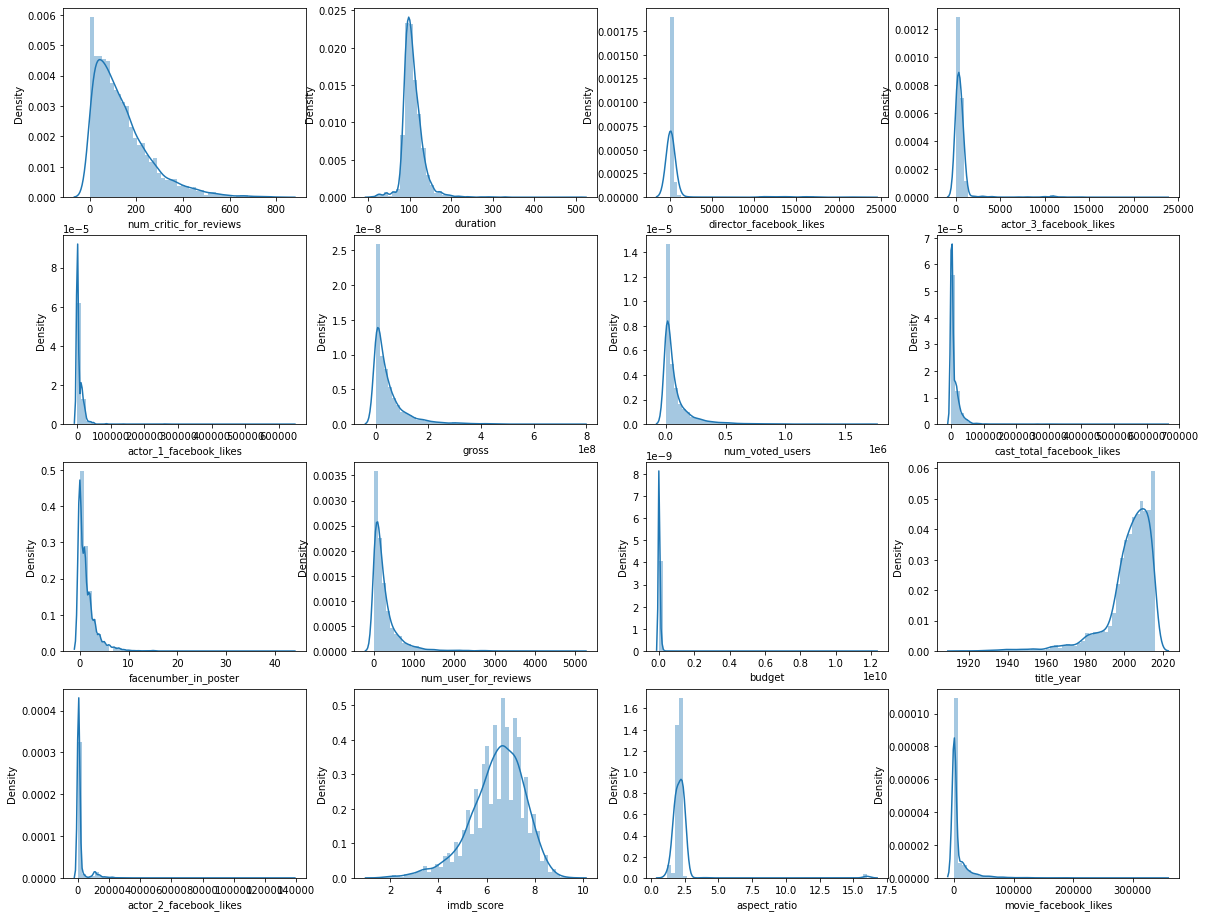

In [1]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 16))
for ax, col in zip(axes.flatten()[:16], numerical):
    sns.distplot(df_raw[col], ax=ax)

plt.show()

### Extract id from url



In [1]:
df = df_raw.copy()

df['id'] = df.movie_imdb_link.map(lambda x: x.split('/')[4])
df.id.head(10)

# Out[10]:
#+BEGIN_EXAMPLE
  0    tt0499549
  1    tt0449088
  2    tt2379713
  3    tt1345836
  4    tt5289954
  5    tt0401729
  6    tt0413300
  7    tt0398286
  8    tt2395427
  9    tt0417741
  Name: id, dtype: object
#+END_EXAMPLE

In [1]:
df.drop('movie_imdb_link', axis=1, inplace=True)

# Out[11]:

In [1]:
df = df.sort_values(by='id')

# Out[12]:

In [1]:
df = df.set_index('id')
df.head()

# Out[13]:
| id        | color           | director_name       |   num_critic_for_reviews |   duration |   director_facebook_likes |   actor_3_facebook_likes | actor_2_name    |   actor_1_facebook_likes |     gross | genres              | actor_1_name   | movie_title                                      |   num_voted_users |   cast_total_facebook_likes | actor_3_name       |   facenumber_in_poster | plot_keywords                                                         |   num_user_for_reviews | language   | country   | content_rating   |     budget |   title_year |   actor_2_facebook_likes |   imdb_score |   aspect_ratio |   movie_facebook_likes |
|-----------+-----------------+---------------------+--------------------------+------------+---------------------------+--------------------------+-----------------+--------------------------+-----------+---------------------+----------------+--------------------------------------------------+-------------------+-----------------------------

### Duplicates



In [1]:
idx = df.index.drop_duplicates(keep=False)
df = df.loc[idx]

# Out[14]:

### Getting rid of bad records



-   Most records still with nans are not movies but TV shows:



In [1]:
df[df.color.isna()]

# Out[15]:
| id        |   color | director_name       |   num_critic_for_reviews |   duration |   director_facebook_likes |   actor_3_facebook_likes | actor_2_name        |   actor_1_facebook_likes |         gross | genres                                                          | actor_1_name       | movie_title                                           |   num_voted_users |   cast_total_facebook_likes | actor_3_name     |   facenumber_in_poster | plot_keywords                                                                   |   num_user_for_reviews | language   | country   | content_rating   |      budget |   title_year |   actor_2_facebook_likes |   imdb_score |   aspect_ratio |   movie_facebook_likes |
|-----------+---------+---------------------+--------------------------+------------+---------------------------+--------------------------+---------------------+--------------------------+---------------+-----------------------------------------------------------------+-----------

-   We get rid of them:



In [1]:
df.content_rating = df.content_rating.fillna('Not Rated')
df = df[~(df.content_rating.str.contains('TV'))]

# Out[16]:

-   Records with no language are from the USA:



In [1]:
df[df.language.isna()]

# Out[17]:
| id        | color           | director_name       |   num_critic_for_reviews |   duration |   director_facebook_likes |   actor_3_facebook_likes | actor_2_name   |   actor_1_facebook_likes |            gross | genres                                                          | actor_1_name            | movie_title                                           |   num_voted_users |   cast_total_facebook_likes | actor_3_name      |   facenumber_in_poster | plot_keywords                                                         |   num_user_for_reviews |   language | country   | content_rating   |       budget |   title_year |   actor_2_facebook_likes |   imdb_score |   aspect_ratio |   movie_facebook_likes |
|-----------+-----------------+---------------------+--------------------------+------------+---------------------------+--------------------------+----------------+--------------------------+------------------+-----------------------------------------------------------------+--

-   We set them to English:



In [1]:
df.loc[df.language.isna(), 'language'] = 'English'

# Out[18]:

In [1]:
df[df.title_year.isna()]

# Out[19]:
| id        | color           | director_name       |   num_critic_for_reviews |   duration |   director_facebook_likes |   actor_3_facebook_likes | actor_2_name             |   actor_1_facebook_likes |   gross | genres                                    | actor_1_name          | movie_title                                |   num_voted_users |   cast_total_facebook_likes | actor_3_name            |   facenumber_in_poster | plot_keywords                                                                                              |   num_user_for_reviews | language   | country   | content_rating   |    budget |   title_year |   actor_2_facebook_likes |   imdb_score |   aspect_ratio |   movie_facebook_likes |
|-----------+-----------------+---------------------+--------------------------+------------+---------------------------+--------------------------+--------------------------+--------------------------+---------+-------------------------------------------+-----------------

-   Those are again TV Series with no pitches and issued over several years so we
    drop them



In [1]:
df = df[~(df.title_year.isna())]
df.shape

# Out[20]:
(4688, 27)

### Casting variables



In [1]:
literal = ['director_name', 'movie_title',
           'actor_2_name', 'actor_3_name',
           'actor_1_name', 'plot_keywords']
categorical = ['color', 'genres',
               'language', 'country', 'content_rating']
numerical = ['num_critic_for_reviews', 'duration', 'gross', 'director_facebook_likes',
             'num_voted_users', 'cast_total_facebook_likes', 'facenumber_in_poster',
             'num_user_for_reviews', 'budget', 'imdb_score',
             'movie_facebook_likes']

# Out[21]:

### genres



In [1]:
df.genres = df.genres.str.split('|')
df.sample(10)

# Out[22]:
| id        | color           | director_name       |   num_critic_for_reviews |   duration |   director_facebook_likes |   actor_3_facebook_likes | actor_2_name   |   actor_1_facebook_likes |            gross | genres                                                  | actor_1_name       | movie_title               |   num_voted_users |   cast_total_facebook_likes | actor_3_name     |   facenumber_in_poster | plot_keywords                                                 |   num_user_for_reviews | language   | country   | content_rating   |     budget |   title_year |   actor_2_facebook_likes |   imdb_score |   aspect_ratio |   movie_facebook_likes |
|-----------+-----------------+---------------------+--------------------------+------------+---------------------------+--------------------------+----------------+--------------------------+------------------+---------------------------------------------------------+--------------------+---------------------------+-------------

In [1]:
mlb = MultiLabelBinarizer()
df_genres = pd.DataFrame(mlb.fit_transform(df.genres), columns=mlb.classes_, index=df.index)
df_genres.sample(20)

# Out[25]:
| id        |   Action |   Adventure |   Animation |   Biography |   Comedy |   Crime |   Documentary |   Drama |   Family |   Fantasy |   Film-Noir |   History |   Horror |   Music |   Musical |   Mystery |   News |   Romance |   Sci-Fi |   Short |   Sport |   Thriller |   War |   Western |
|-----------+----------+-------------+-------------+-------------+----------+---------+---------------+---------+----------+-----------+-------------+-----------+----------+---------+-----------+-----------+--------+-----------+----------+---------+---------+------------+-------+-----------|
| tt0139462 |        0 |           0 |           0 |           0 |        0 |       0 |             0 |       1 |        0 |         0 |           0 |         0 |        0 |       0 |         0 |         0 |      0 |         1 |        0 |       0 |       0 |          0 |     0 |         0 |
| tt0242998 |        0 |           0 |           0 |           0 |        0 |       0 |             0 |       

In [1]:
df.drop('genres', axis=1, inplace=True)

# Out[26]:

### plots



In [1]:
df.plot_keywords.head()

# Out[27]:
#+BEGIN_EXAMPLE
  id
  tt0006864      huguenot|intolerance|medicis|protestant|wedding
  tt0011549      family relationships|gang|idler|poorhouse|thief
  tt0015624    chewing gum|climbing a tree|france|translation...
  tt0017136        art deco|bible quote|dance|silent film|worker
  tt0018737    escape|femme fatale|german expressionism|lust|...
  Name: plot_keywords, dtype: object
#+END_EXAMPLE

In [1]:
df.plot_keywords = df.plot_keywords.str.replace('|', ", ")

# Out[28]:

In [1]:
df.sample(10)

# Out[29]:
| id        | color   | director_name       |   num_critic_for_reviews |   duration |   director_facebook_likes |   actor_3_facebook_likes | actor_2_name    |   actor_1_facebook_likes |            gross | actor_1_name      | movie_title                 |   num_voted_users |   cast_total_facebook_likes | actor_3_name             |   facenumber_in_poster | plot_keywords                                                          |   num_user_for_reviews | language   | country   | content_rating   |      budget |   title_year |   actor_2_facebook_likes |   imdb_score |   aspect_ratio |   movie_facebook_likes |
|-----------+---------+---------------------+--------------------------+------------+---------------------------+--------------------------+-----------------+--------------------------+------------------+-------------------+-----------------------------+-------------------+-----------------------------+--------------------------+------------------------+---------------------

### KNN Imputation of numerical variables



In [1]:
imputer = KNNImputer(n_neighbors=5)
df_num = pd.DataFrame(imputer.fit_transform(df[numerical]),columns = df[numerical].columns)
df_num.sample(20)

# Out[30]:
|      |   num_critic_for_reviews |   duration |           gross |   director_facebook_likes |   num_voted_users |   cast_total_facebook_likes |   facenumber_in_poster |   num_user_for_reviews |      budget |   imdb_score |   movie_facebook_likes |
|------+--------------------------+------------+-----------------+---------------------------+-------------------+-----------------------------+------------------------+------------------------+-------------+--------------+------------------------|
| 1749 |                       84 |        280 |     1.28706e+07 |                        33 |             13215 |                        1671 |                      0 |                    497 | 5.6e+07     |          6.3 |                    953 |
| 2237 |                       35 |        128 |     2.69407e+06 |                         9 |              3222 |                        1727 |                      3 |                     64 | 5.22e+06    |          6.7 |                   

In [1]:
df.drop(numerical, axis=1, inplace=True)
df.head()

# Out[31]:
| id        | color           | director_name       |   actor_3_facebook_likes | actor_2_name    |   actor_1_facebook_likes | actor_1_name   | movie_title                                      | actor_3_name       | plot_keywords                                                             | language   | country   | content_rating   |   title_year |   actor_2_facebook_likes |   aspect_ratio |
|-----------+-----------------+---------------------+--------------------------+-----------------+--------------------------+----------------+--------------------------------------------------+--------------------+---------------------------------------------------------------------------+------------+-----------+------------------+--------------+--------------------------+----------------|
| tt0006864 | Black and White | D.W. Griffith       |                        9 | Mae Marsh       |                      436 | Lillian Gish   | Intolerance: Love's Struggle Throughout the Ages | Walter 

### Getting it all back together



-   Let's check everything is in good shape



In [1]:
df_num.shape, df_genres.shape

# Out[32]:
((4688, 11), (4688, 24))

-   Concatenate genras



In [1]:
df = pd.concat([df, df_genres], axis = 1)

# Out[33]:

-   Concatenate numericals



In [1]:
df = df.reset_index()
df = pd.concat([df, df_num], axis = 1)

# Out[34]:

In [1]:
df

0 - 0a8c8064-543f-4605-97b6-9247837709b7

In [1]:
#display_all(df.describe(include='all').T)

dg = df.iloc[:,16:40]
for genre in dg.columns:
    print(dg.groupby(genre).groups)

# Out[32]:

### Save data



In [1]:
df.to_csv('../data/processed/movie_metadata_processed.csv')

# Out[33]:

## Bibliography



### References:PROPERTIES:




[../references/recsys.bib](../references/recsys.bib)

